In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline



env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

W0921 21:50:03.145820 140335261579072 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W0921 21:50:03.184818 140335261579072 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import segmentation_models_pytorch as smp

In [4]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
mumbai = data_dir/"AOI_8_Mumbai"
ms_mumbai = mumbai/"MS"
ps_rgb_mumbai = mumbai/"PS-RGB"
mask_folder = mumbai / "masks"

In [5]:
from utils import create_small_tiles, scale_percentile

In [6]:
mask_folder = mumbai / "masks"

mask_512_folder = mumbai /"masks_512"
mask_512_folder.mkdir(exist_ok=True)

rgb_512_folder = mumbai /"rgb_512"
rgb_512_folder.mkdir(exist_ok=True)

img_fnames = ps_rgb_mumbai.ls()
img_ids = [x.name.replace('.tif', '').split('_')[-1] for x in img_fnames]
mask_fnames =[ mask_folder / f"{img_id}.png" for img_id in img_ids]



In [7]:
valid_imgs = list(set([x.name.split('_')[2] for x in rgb_512_folder.ls() if x.name.endswith('.jpg')]))
np.random.seed(42)
mumbai_ids = np.array(valid_imgs)
np.random.shuffle(mumbai_ids)
np.random.seed(None)

In [8]:
len(valid_imgs), len(mumbai_ids)

train_ids = mumbai_ids[:int(0.8*len(mumbai_ids))]
valid_ids = mumbai_ids[int(0.8*len(mumbai_ids)):]

print(len(train_ids), len(valid_ids))

512 129


#### modelling setup

using a previously saved set of train/validation splits

In [9]:
train_val_ids_df = pd.read_csv(data_dir /"train_val_split_ids.csv")
train_ids= train_val_ids_df[train_val_ids_df.is_train ==True]['id'].to_numpy()
valid_ids= train_val_ids_df[train_val_ids_df.is_train ==False]['id'].to_numpy()

In [10]:
valid_ids

array(['chip932', 'chip37', 'chip417', 'chip48', ..., 'chip523', 'chip796', 'chip494', 'chip66'], dtype=object)

In [11]:
def get_mask_fn(fname):
    return mask_512_folder / fname.name.replace("rgb", "mask").replace("jpg", "png")


def is_valid_image(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in mumbai_ids

def is_in_validation_set(filepath):
    
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in valid_ids

codes = np.array(["void", "road"])

src = (SegmentationItemList.from_folder(rgb_512_folder)
       .filter_by_func(is_valid_image)
       .split_by_valid_func(is_in_validation_set)
       .label_from_func(get_mask_fn, classes=codes)
      )

bs = 4
size=256

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

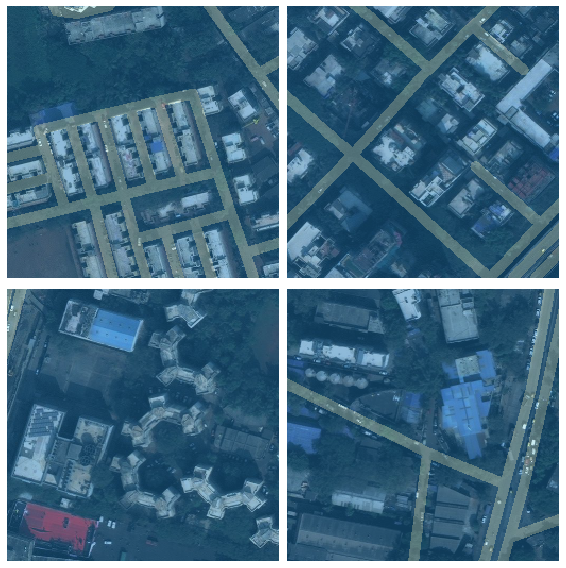

In [13]:
data.show_batch(ds_type=DatasetType.Valid)

In [12]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['void','road']

linknet = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), )

In [13]:
linknet

Linknet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [14]:
wd =1e-2
metrics = [partial(foreground_acc, void_code=0),dice]
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
# learn.to_fp16()

learn = Learner(data, linknet, metrics=metrics)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (3960 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (15926 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None, model=Linknet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-0

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


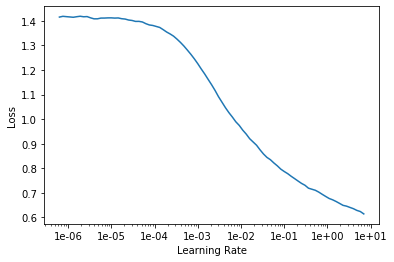

In [15]:
learn.recorder.plot(skip_end=1)

In [16]:
lr=1e-3
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-linknet-enc-se_resnext50_32x4d-1')]
learn.fit_one_cycle(10, slice(lr), callbacks=callbacks)

Better model found at epoch 0 with dice value: 0.40495556592941284.
Better model found at epoch 1 with dice value: 0.49061378836631775.
Better model found at epoch 4 with dice value: 0.49785682559013367.
Better model found at epoch 5 with dice value: 0.5077309012413025.
Better model found at epoch 6 with dice value: 0.5315715670585632.
Better model found at epoch 7 with dice value: 0.5365566611289978.
Better model found at epoch 9 with dice value: 0.5527703166007996.


In [17]:
learn.load('mumbai-model-linknet-enc-se_resnext50_32x4d-1');

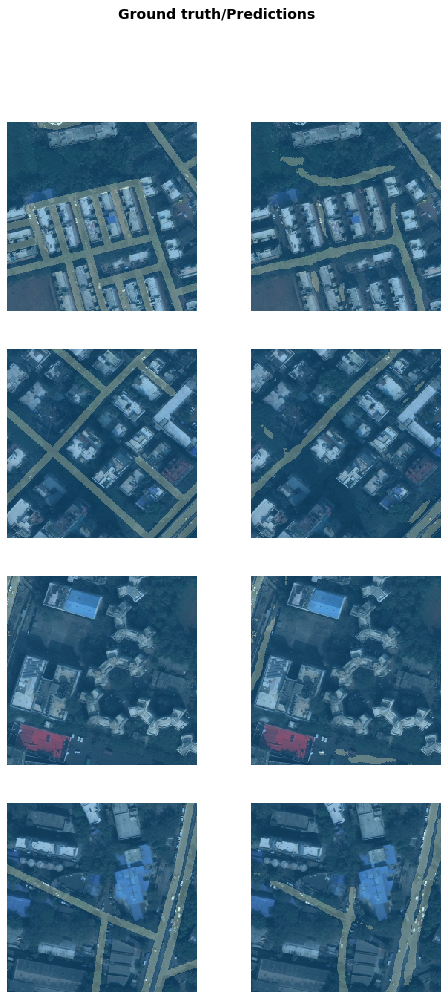

In [18]:
learn.show_results()

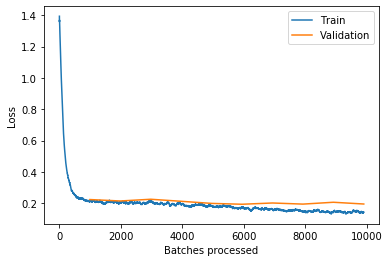

In [20]:
# learn.lr_find()
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


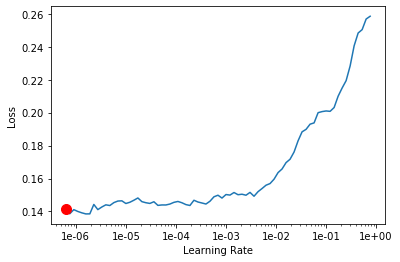

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [22]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-linknet-enc-se_resnext50_32x4d-2'),
          TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=2)
          ]

lr=1e-6
learn.fit_one_cycle(10, slice(lr), callbacks=callbacks)

Better model found at epoch 0 with dice value: 0.5509539246559143.
Better model found at epoch 1 with dice value: 0.5541613698005676.
Epoch 4: reducing lr to 1.6234913078995263e-07
Epoch 7: reducing lr to 3.7651669210047405e-08


In [31]:
learn.load('mumbai-model-linknet-enc-se_resnext50_32x4d-2')
size=512
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn.data

ImageDataBunch;

Train: LabelList (3960 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (15926 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 5.25E-04


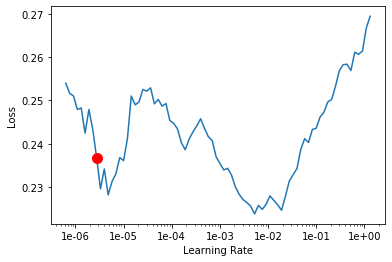

In [33]:

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [34]:

callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-linknet-enc-se_resnext50_32x4d-3'),
          TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=2)
          ]
lr=1e-6
learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)


Better model found at epoch 0 with dice value: 0.30129897594451904.
Better model found at epoch 1 with dice value: 0.3567170202732086.
Better model found at epoch 2 with dice value: 0.38223958015441895.
Better model found at epoch 3 with dice value: 0.3833363652229309.
Better model found at epoch 4 with dice value: 0.3915519416332245.


hmm, the bigger size doesn't seem to have helped at all...
dice score wise, it's about the same as the unet, although, it's also true that the training seems to be more stable.

#### predictions

Let's look at how the model does on the validation set:

In [26]:
learn.load('mumbai-model-linknet-enc-se_resnext50_32x4d-2');
preds = []
ys = []
model = learn.model
model.eval()
dl = learn.dl(DatasetType.Valid)
with torch.no_grad():
    for xb,yb in progress_bar(dl):
        pred = model(xb)
        preds.append(to_detach(pred))
        ys.append(yb.cpu())
del pred
gc.collect()
torch.cuda.empty_cache()

In [31]:
torch.softmax

In [16]:
# predictions = learn.get_preds()
from fastai.basic_train import validate
from types import MethodType
def get_preds(model:nn.Module, dl:DataLoader, pbar:Optional[PBar]=None, cb_handler:Optional[CallbackHandler]=None,
              activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[int]=None) -> List[Tensor]:
    "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
    res = [torch.cat(o.cpu()) for o in
           zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch))]
    if loss_func is not None:
        with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))
    if activ is not None: res[0] = activ(res[0])
    return res

def learner_get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None) -> List[Tensor]:
        "Return predictions and targets on `ds_type` dataset."
        lf = self.loss_func if with_loss else None
        activ = ifnone(activ, _loss_func2activ(self.loss_func))
        if not self.cb_fns_registered:
            lr,wd = self.lr_range(defaults.lr),self.wd
            if not getattr(self, 'opt', False): self.create_opt(lr, wd)
            else: self.opt.lr,self.opt.wd = lr,wd
            self.callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(self.callbacks)
            self.cb_fns_registered = True
        return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(self.callbacks),
                         activ=activ, loss_func=lf, n_batch=n_batch, pbar=pbar)
    
    
learn.get_preds = MethodType(learner_get_preds, learn)

In [17]:
predictions = learn.get_preds()

NameError: name '_loss_func2activ' is not defined

In [ ]:
prediction_masks_512= nn.UpsamplingNearest2d(scale_factor=2)(predictions[0])

In [41]:
learn.data.valid_dl.x.items

array([PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip313_680_510.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip62_340_0.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip307_170_680.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip180_340_170.jpg'), ...,
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip668_680_0.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip195_510_788.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip805_340_510.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip244_510_510.jpg')],
      dtype=object)

In [52]:
to_combine = []
mask_width = predictions[0][0].shape[1]
full_img_width = 1300//2 # this is becuase we resized the mask to be 1/2
for mask, fpath in zip(predictions[0],learn.data.valid_dl.x.items):
    full_img = np.zeros((full_img_width,full_img_width))

    start_index_row, start_index_col = [int(x)//2 for x in fpath.name.replace('.jpg','').split('_')[3:]]

    full_img[start_index_row:start_index_row+mask_width, start_index_col: start_index_col+mask_width] = torch.argmax(mask,0).numpy()
    to_combine.append(full_img)


In [97]:
def process_one_img(img_id, predictions, filepaths_list):
    to_combine = []
    valid_idx_mask = [x.name.split('_')[2] == img_id for x in filepaths_list]
#     valid_idx_mask = [x.name.split('_')[2] == img_id for x in learn.data.valid_dl.x.items]
    fpaths = filepaths_list[list(np.argwhere(valid_idx_mask).ravel())]
#     fpaths = learn.data.valid_dl.x.items[list(np.argwhere(valid_idx_mask).ravel())]
    for mask, fpath in zip(predictions[0][valid_idx_mask], fpaths):
        full_img = np.zeros((full_img_width,full_img_width))

        start_index_row, start_index_col = [int(x)//2 for x in fpath.name.replace('.jpg','').split('_')[3:]]


        full_img[start_index_row:start_index_row+mask_width, start_index_col: start_index_col+mask_width] = torch.argmax(mask,0).numpy()
        to_combine.append(full_img)
    out = np.sum(np.array(to_combine), axis=0)
    out=np.clip(out, 0,1)
    return out


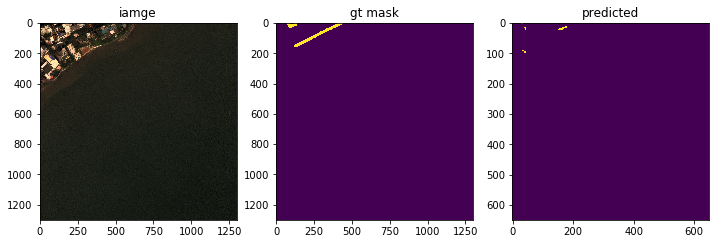

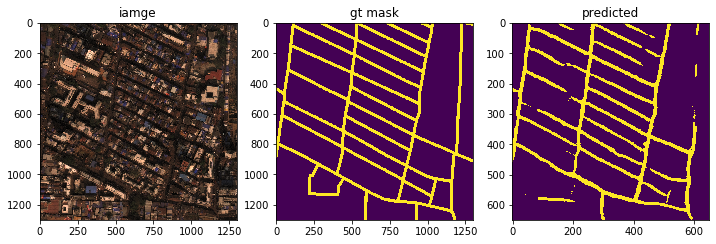

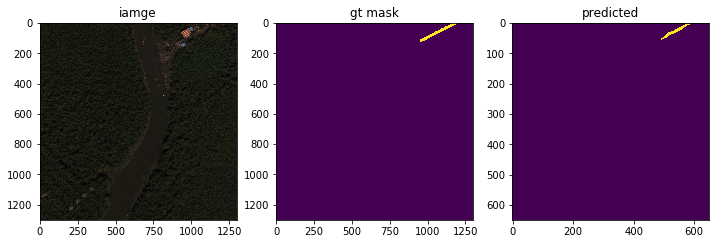

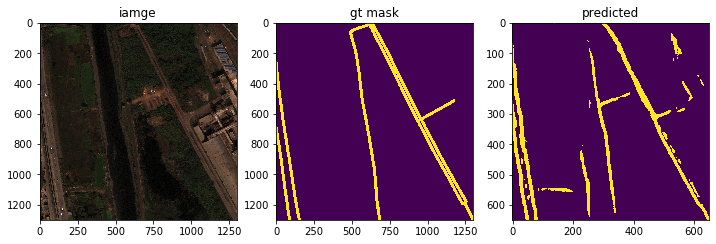

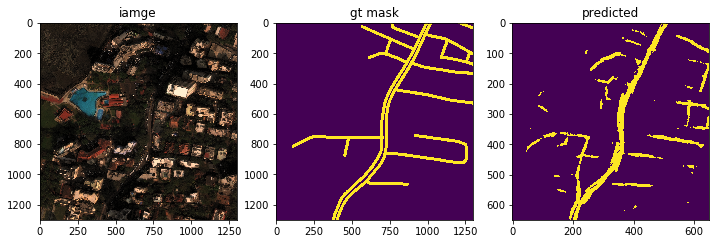

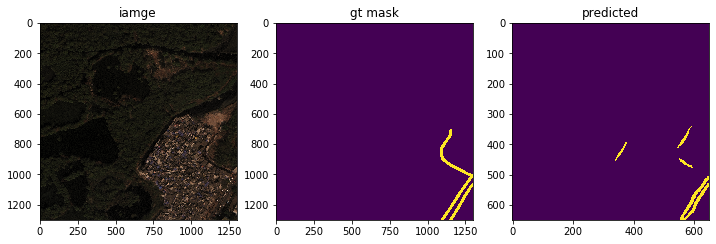

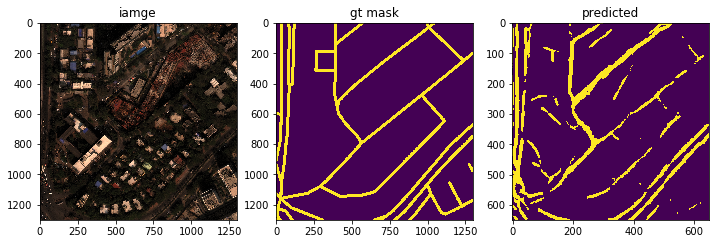

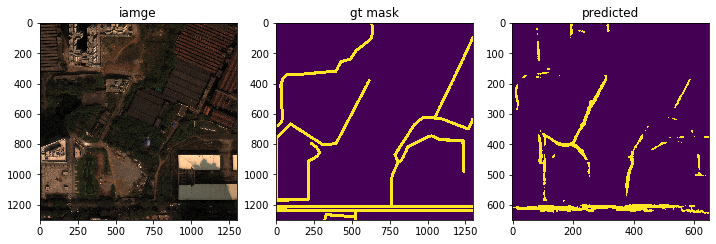

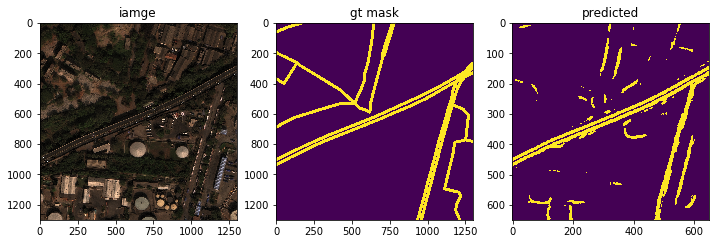

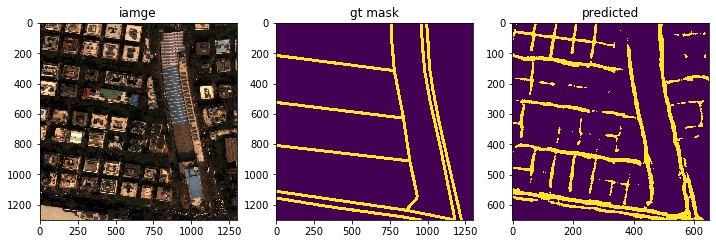

In [99]:
for img_id in valid_ids[:10]:
    predicted= process_one_img(img_id,predictions, learn.data.valid_dl.x.items)
    image = sktif.imread(str(ps_rgb_mumbai / f"SN5_roads_train_AOI_8_Mumbai_PS-RGB_{img_id}.tif"))
    mask = PIL.Image.open(mask_folder/f"{img_id}.png")
    fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(12,8))
    ax = axes.ravel()

    ax[0].imshow(image);
    ax[0].set_title('image');
    ax[1].imshow(mask);
    ax[1].set_title('gt mask');
    ax[2].imshow(predicted);
    ax[2].set_title('predicted');

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


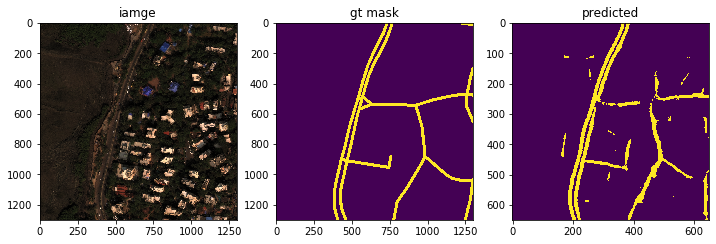

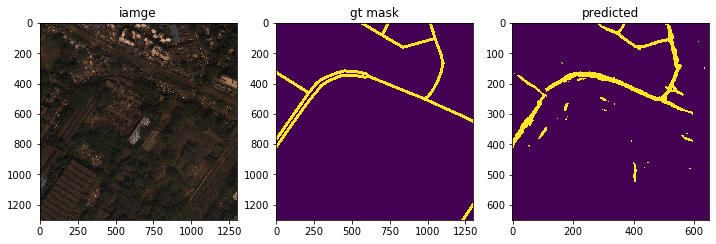

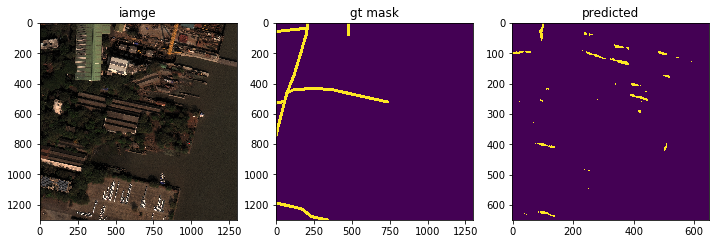

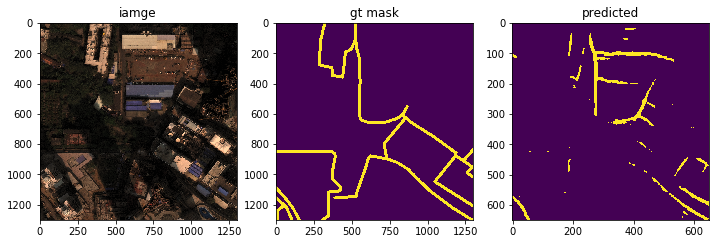

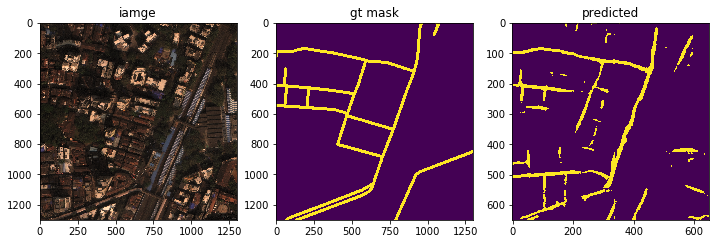

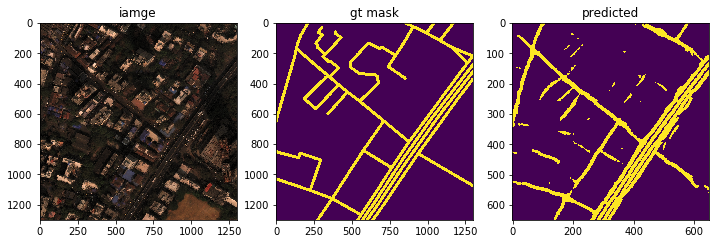

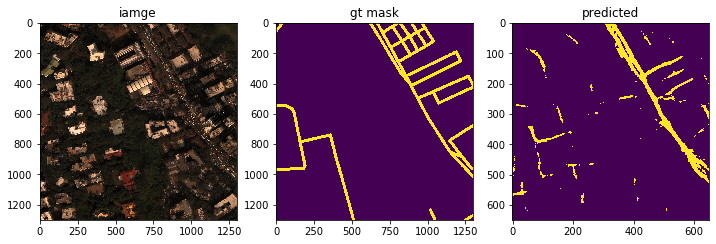

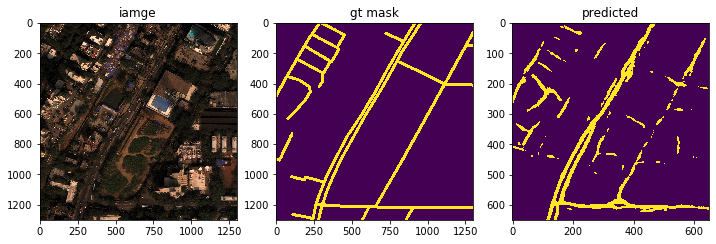

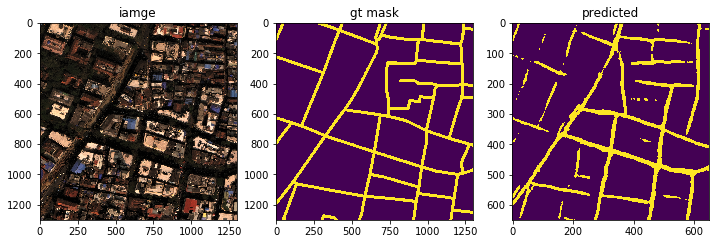

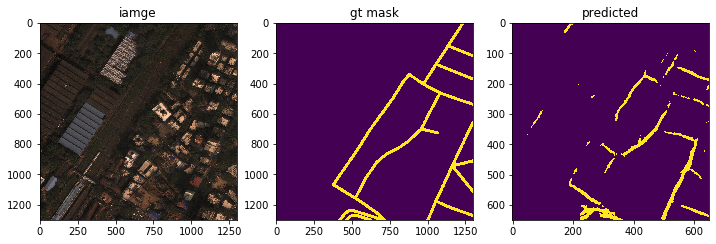

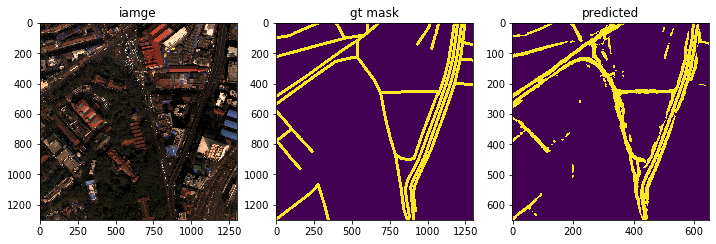

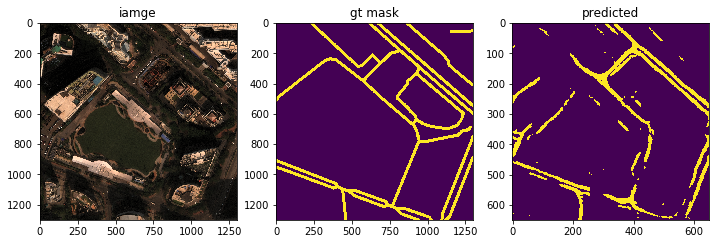

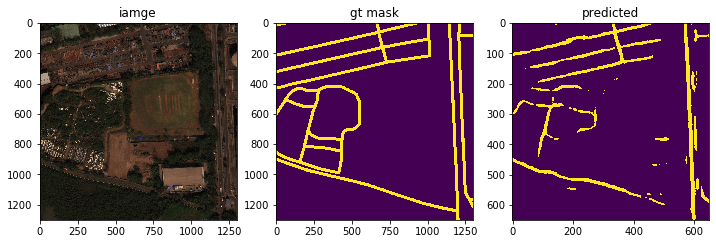

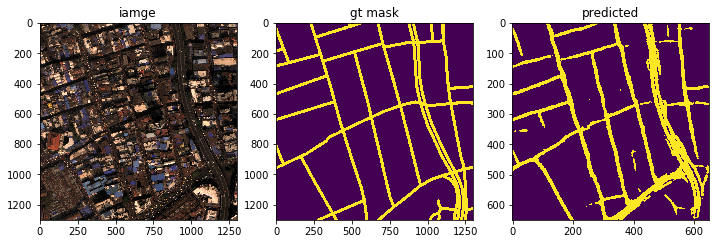

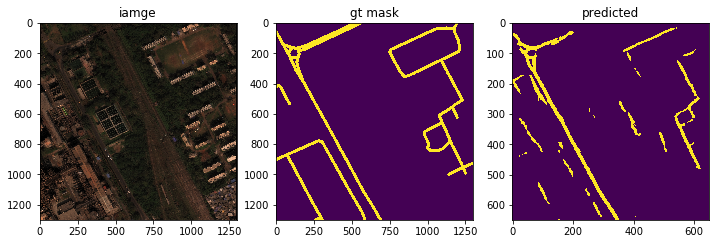

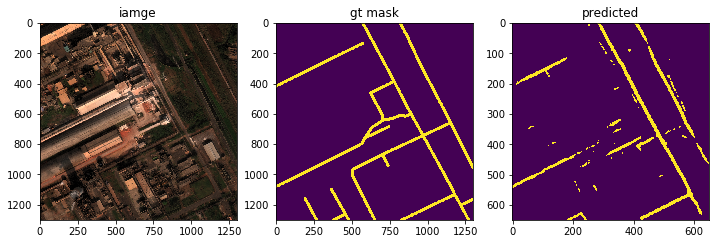

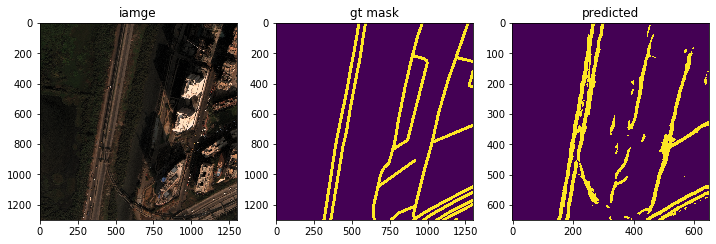

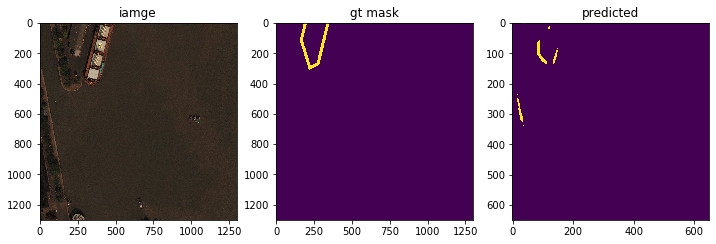

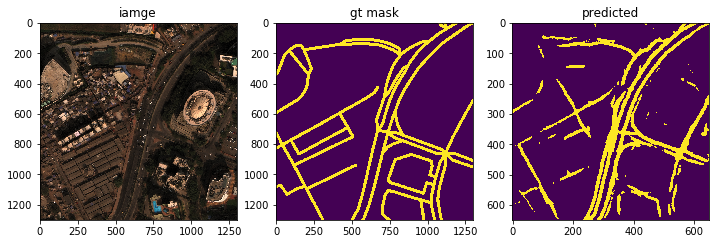

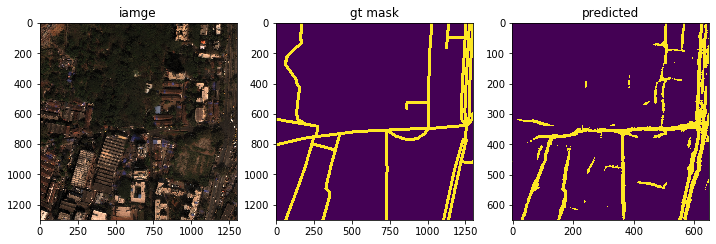

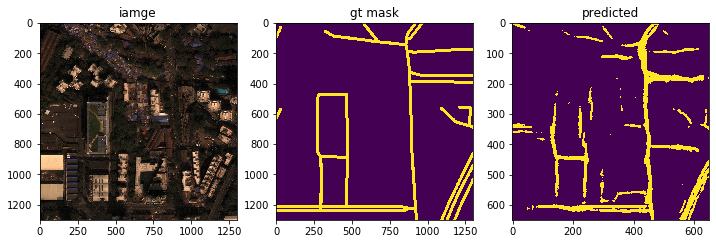

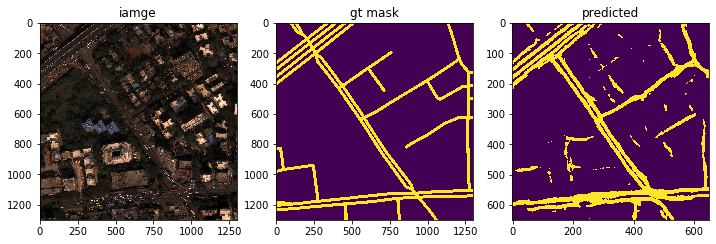

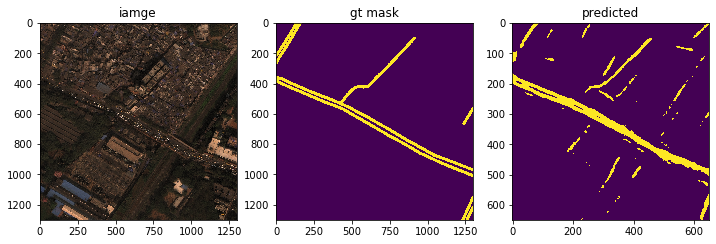

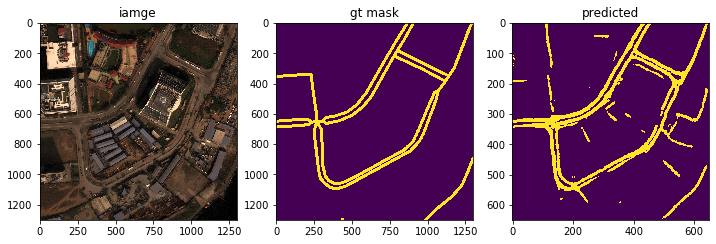

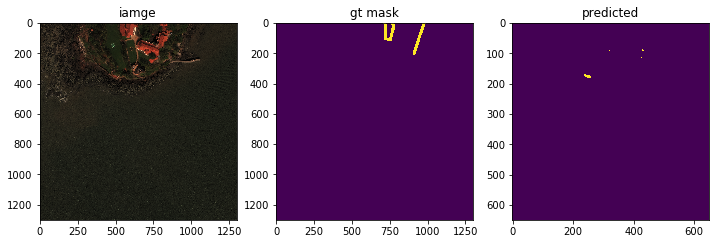

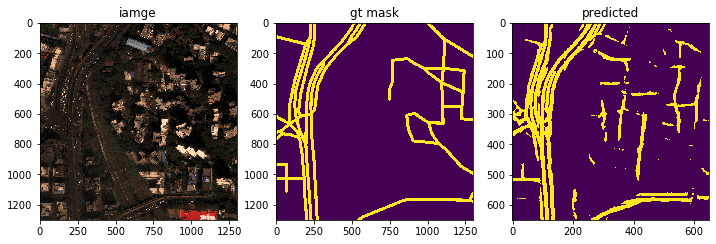

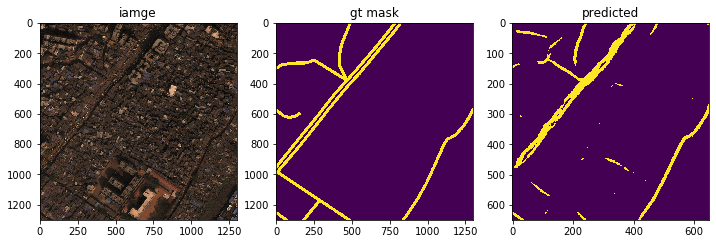

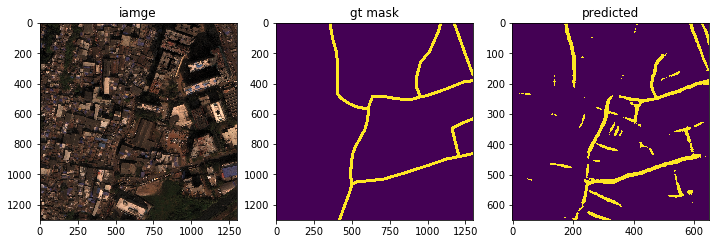

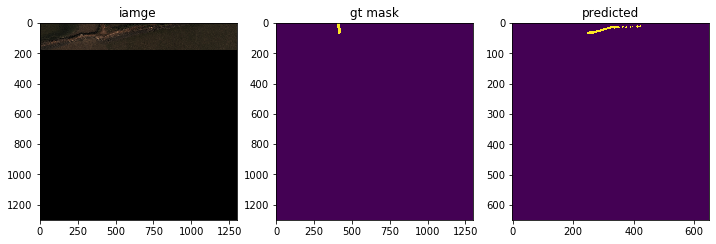

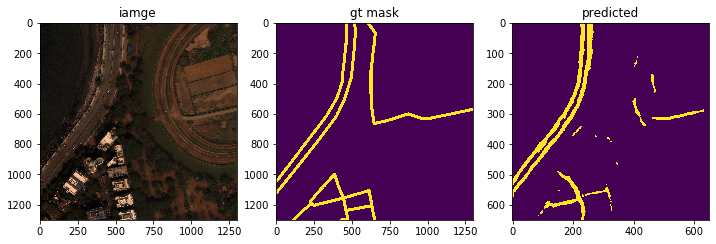

In [102]:
for img_id in valid_ids[10:40]:
    predicted= process_one_img(img_id,predictions, learn.data.valid_dl.x.items)
    image = sktif.imread(str(ps_rgb_mumbai / f"SN5_roads_train_AOI_8_Mumbai_PS-RGB_{img_id}.tif"))
    mask = PIL.Image.open(mask_folder/f"{img_id}.png")
    fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(12,8))
    ax = axes.ravel()

    ax[0].imshow(image);
    ax[0].set_title('iamge');
    ax[1].imshow(mask);
    ax[1].set_title('gt mask');
    ax[2].imshow(predicted);
    ax[2].set_title('predicted');
    
    fig.close()

not bad, getting there...

In [105]:
# one final sanity check that we're not training and predicting on the same images...
a = set([x.name.split('_')[2] for x in learn.data.valid_dl.x.items])
b = set([x.name.split('_')[2] for x in learn.data.train_dl.x.items])

a.intersection(b)

set()

In [30]:
data

ImageDataBunch;

Train: LabelList (3960 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (15926 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None